In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 30

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [15]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e6 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [16]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [18]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, HybridDPLL)
    # compute_and_print_steps(sats, ShortCommonDPLL)
    logfile.flush()

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:18<00:00,  1.66s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 159.70; stdev step: 233.83; avg error: 1.10; stdev error: 1.70


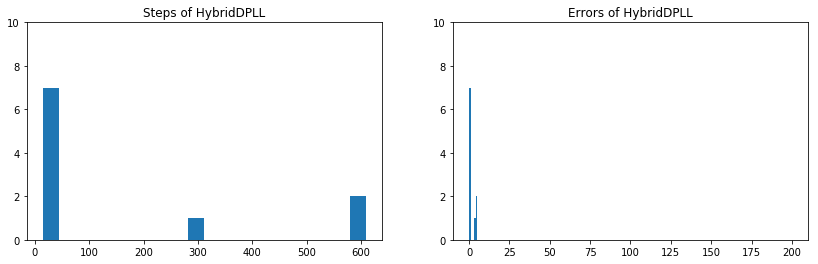

100%|██████████| 10/10 [00:00<00:00, 32.00it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 276.50; stdev step: 174.11; avg error: 2.50; stdev error: 0.81


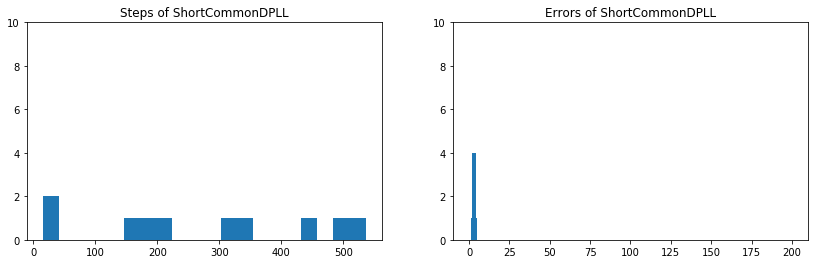

In [18]:
print_all(10, 200, 15)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 15.30; stdev step: 18.90; avg error: 0.10; stdev error: 0.30


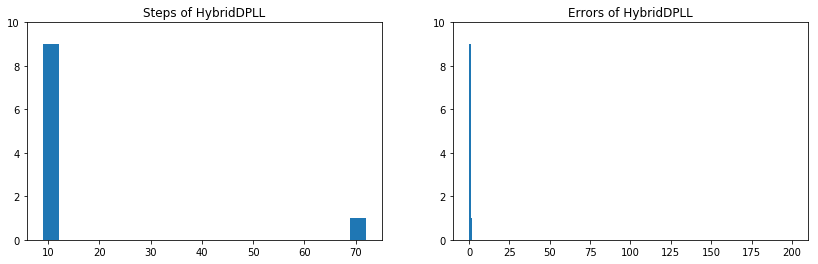

100%|██████████| 10/10 [00:00<00:00, 331.09it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 26.20; stdev step: 20.52; avg error: 1.20; stdev error: 0.75


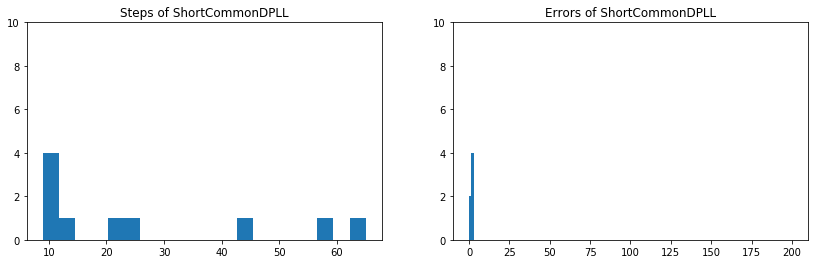

In [19]:
print_all(10, 200, 8)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 14.30; stdev step: 10.24; avg error: 0.10; stdev error: 0.30


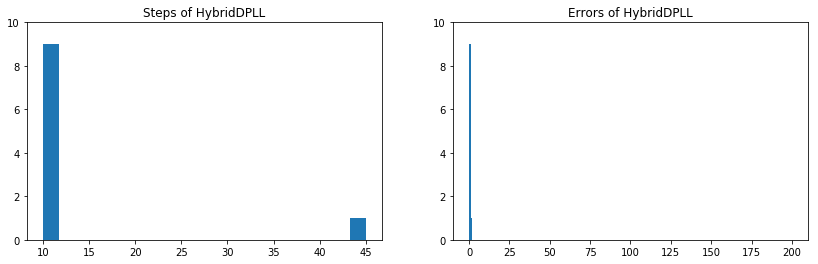

100%|██████████| 10/10 [00:00<00:00, 153.83it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 50.70; stdev step: 57.20; avg error: 1.20; stdev error: 0.75


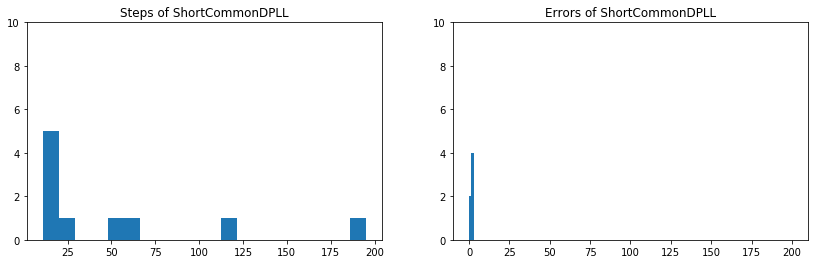

In [20]:
print_all(10, 200, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:11<00:00,  1.73s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 59.10; stdev step: 105.70; avg error: 0.50; stdev error: 1.20


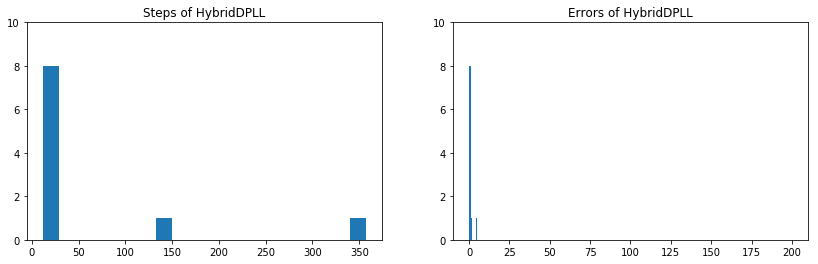

100%|██████████| 10/10 [00:00<00:00, 150.92it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 117.80; stdev step: 109.62; avg error: 2.00; stdev error: 1.26


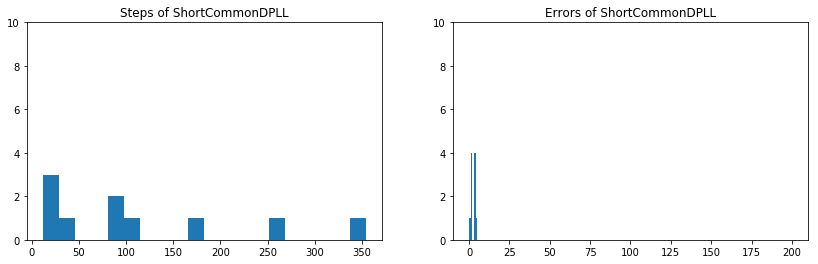

In [21]:
print_all(10, 200, 12)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:12<00:00,  2.06s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 77.70; stdev step: 149.35; avg error: 0.40; stdev error: 0.92


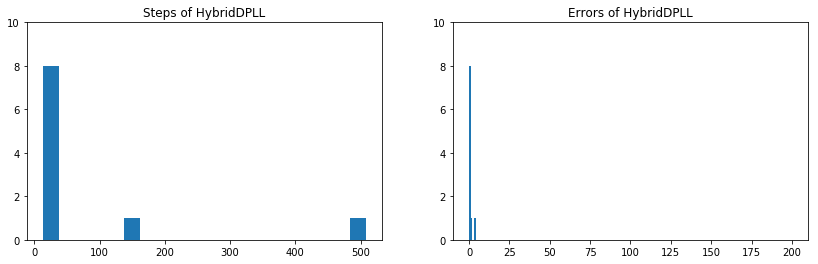

100%|██████████| 10/10 [00:00<00:00, 130.13it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 126.60; stdev step: 125.93; avg error: 2.00; stdev error: 1.10


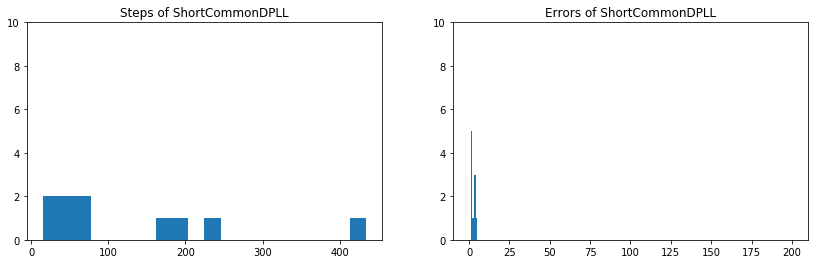

In [22]:
print_all(10, 200, 14)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:23<00:00,  3.07s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 320.90; stdev step: 355.50; avg error: 1.60; stdev error: 1.80


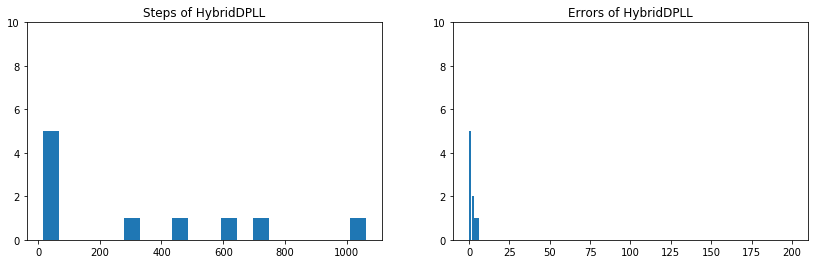

100%|██████████| 10/10 [00:00<00:00, 31.55it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 259.30; stdev step: 211.99; avg error: 2.90; stdev error: 1.30


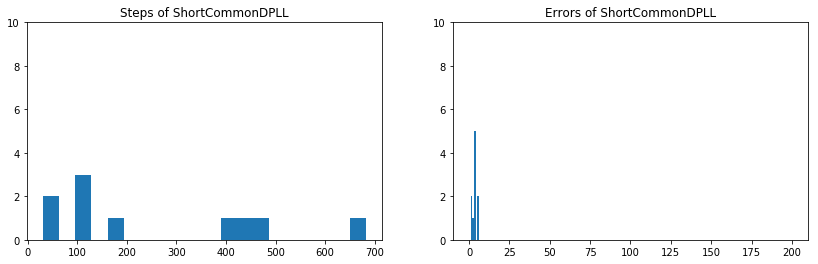

In [23]:
print_all(10, 200, 16)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:18<00:00,  1.61s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 229.50; stdev step: 372.69; avg error: 1.00; stdev error: 1.67


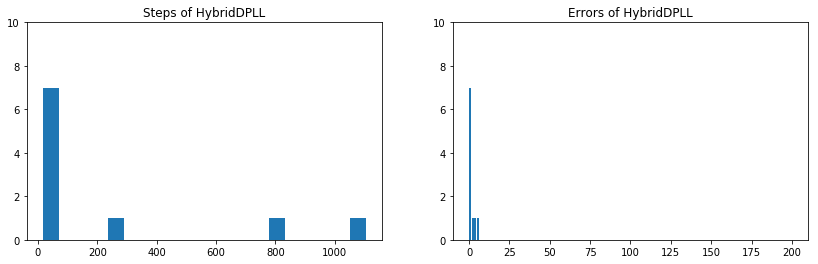

100%|██████████| 10/10 [00:00<00:00, 28.70it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 671.30; stdev step: 525.25; avg error: 3.10; stdev error: 1.14


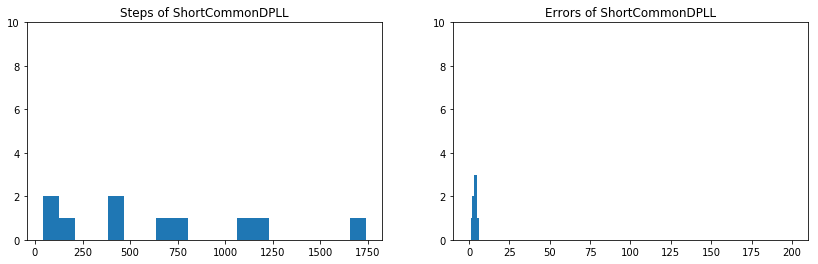

In [24]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:22<00:00,  3.14s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 485.20; stdev step: 893.30; avg error: 1.30; stdev error: 2.00


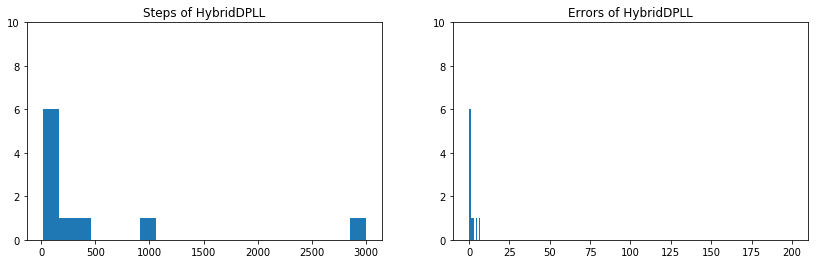

100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 1228.20; stdev step: 1127.89; avg error: 3.10; stdev error: 1.81


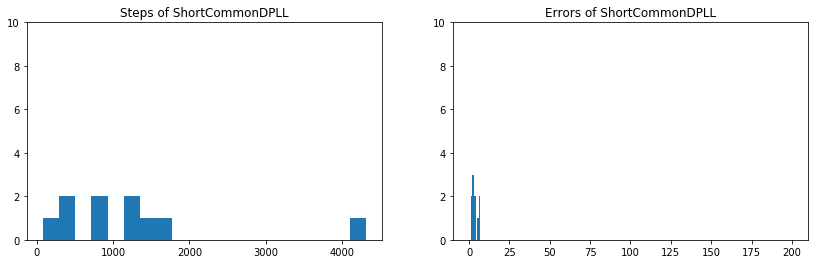

In [25]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:22<00:00,  1.77s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 147.90; stdev step: 261.18; avg error: 0.60; stdev error: 1.20


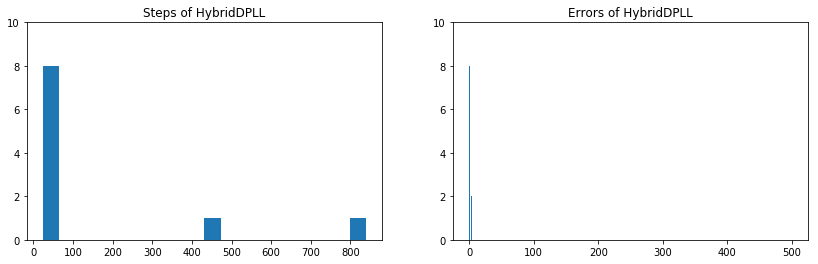

100%|██████████| 10/10 [00:02<00:00,  3.15it/s]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 2632.50; stdev step: 1984.56; avg error: 3.50; stdev error: 1.36


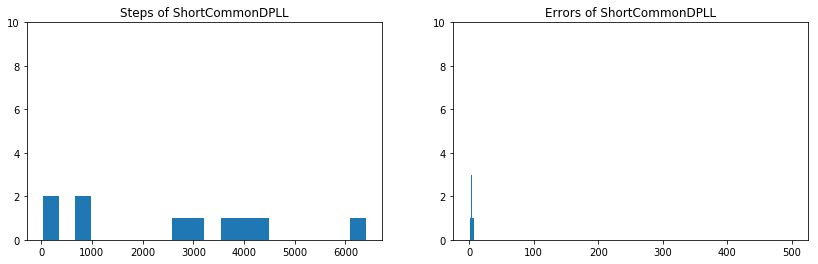

In [26]:
print_all(10, 500, 25, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:45<00:00,  4.19s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 11226.60; stdev step: 17376.54; avg error: 2.30; stdev error: 2.90


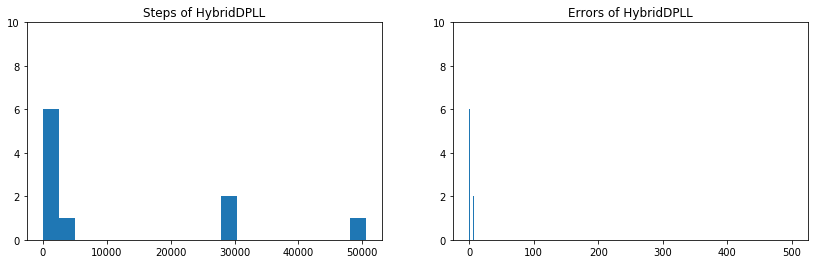

100%|██████████| 10/10 [00:16<00:00,  1.32s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 17963.00; stdev step: 15807.96; avg error: 5.60; stdev error: 1.69


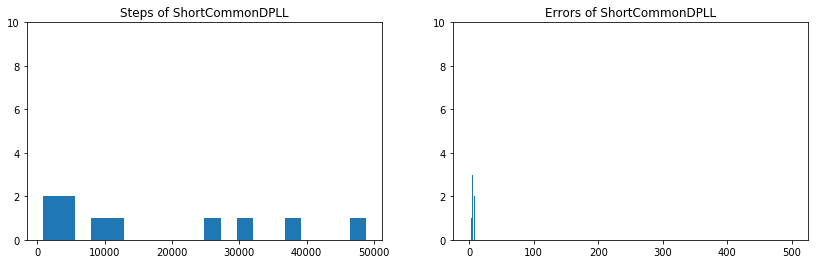

In [27]:
print_all(10, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [01:28<00:00,  7.82s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 29255.30; stdev step: 64588.15; avg error: 3.30; stdev error: 2.79


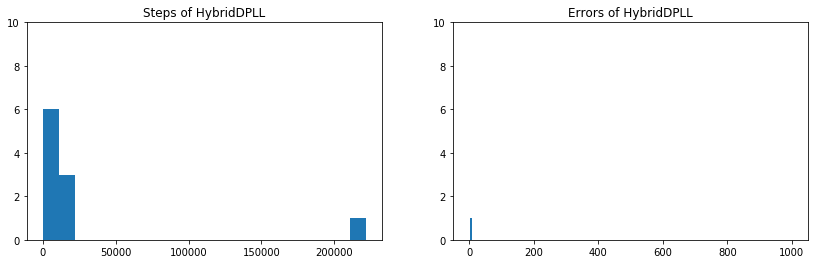

100%|██████████| 10/10 [04:34<00:00, 22.18s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 230695.90; stdev step: 179105.25; avg error: 5.80; stdev error: 1.47


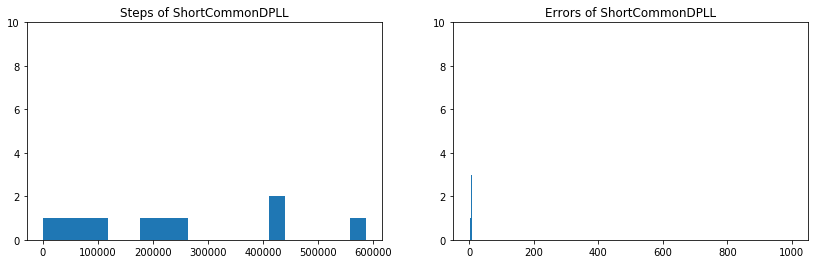

In [28]:
print_all(10, 1000, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [14:56<00:00, 102.38s/it]


Within 1e6 steps solved 4 problems out of 10
#Sats: 4; avg step: 79886.75; stdev step: 130773.71; avg error: 3.25; stdev error: 3.27


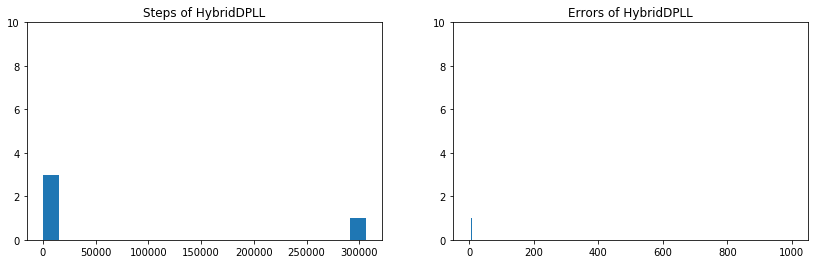

100%|██████████| 10/10 [18:32<00:00, 103.99s/it]


Within 1e6 steps solved 3 problems out of 10
#Sats: 3; avg step: 250356.67; stdev step: 155148.53; avg error: 7.33; stdev error: 2.05


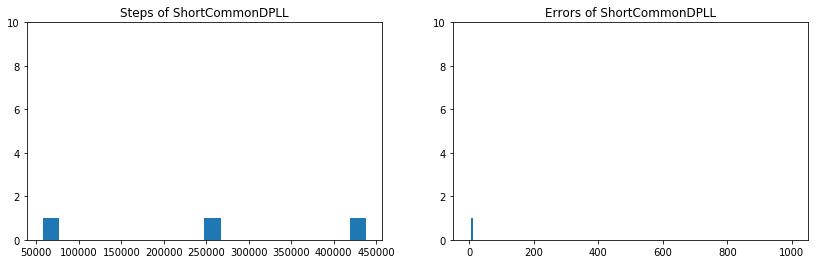

In [29]:
print_all(10, 1000, 50, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [19:16<00:00, 137.77s/it]


Within 1e6 steps solved 3 problems out of 10
#Sats: 3; avg step: 69.67; stdev step: 1.25; avg error: 0.00; stdev error: 0.00


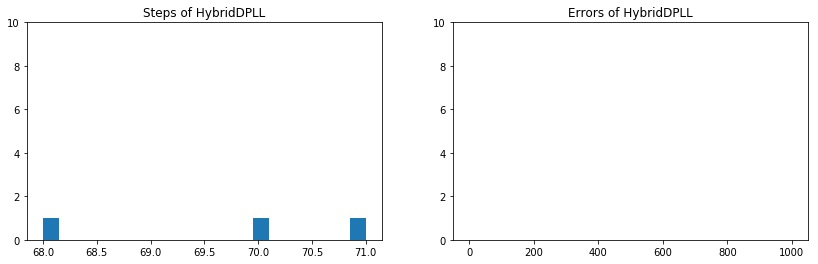

100%|██████████| 10/10 [31:13<00:00, 184.95s/it]
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/henryk.michalewski/sat-solving/deepsat_env/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

Within 1e6 steps solved 0 problems out of 10
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


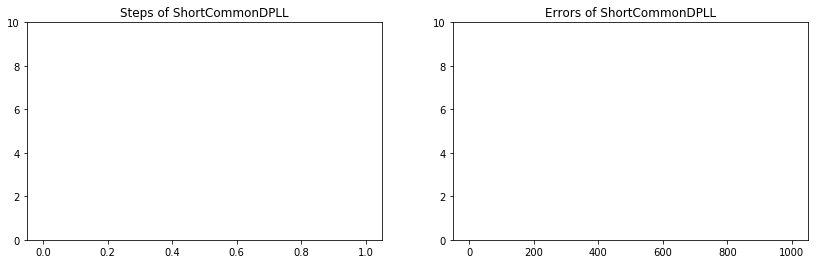

In [30]:
print_all(10, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 90, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


 95%|█████████▌| 95/100 [3:53:28<14:51, 178.23s/it]  

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [03:32<00:00, 15.00s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 122952.50; stdev step: 225829.18; avg error: 2.60; stdev error: 3.04


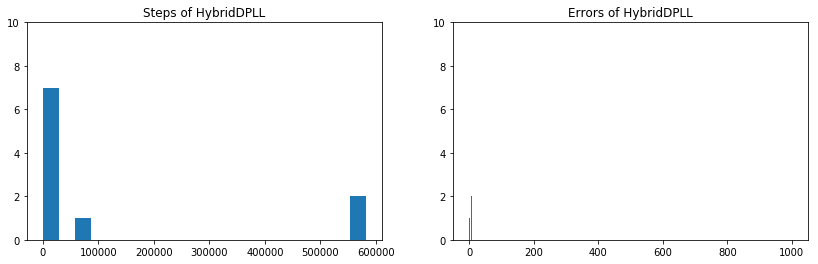

100%|██████████| 10/10 [02:25<00:00, 18.45s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 118163.70; stdev step: 99718.64; avg error: 5.80; stdev error: 1.60


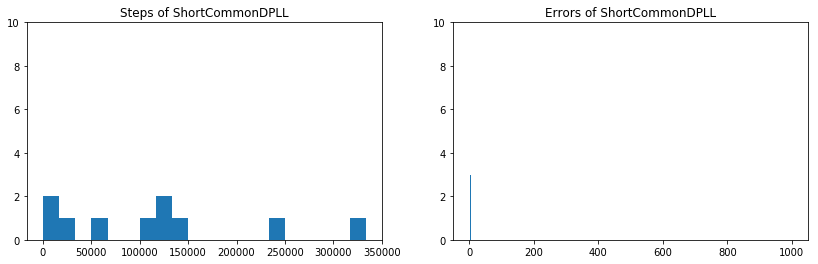

In [32]:
print_all(10, 1000, 40, light=True)

In [ ]:
print_all(100, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 60, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:35<00:00,  3.39s/it]


Within 1e6 steps solved 10 problems out of 10
#Sats: 10; avg step: 2755.10; stdev step: 4056.44; avg error: 2.20; stdev error: 2.40


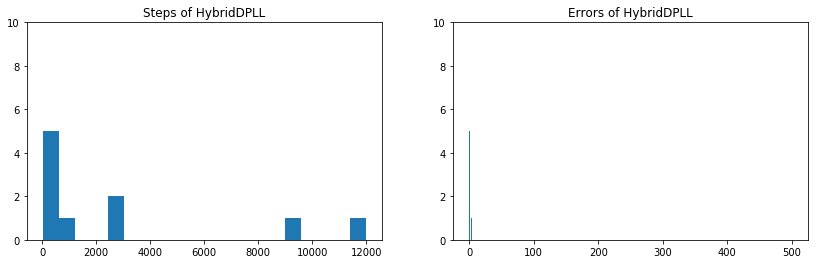

In [19]:
print_all(10, 500, 25, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [07:27<00:00,  4.70s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 6692.72; stdev step: 11699.99; avg error: 2.48; stdev error: 2.91


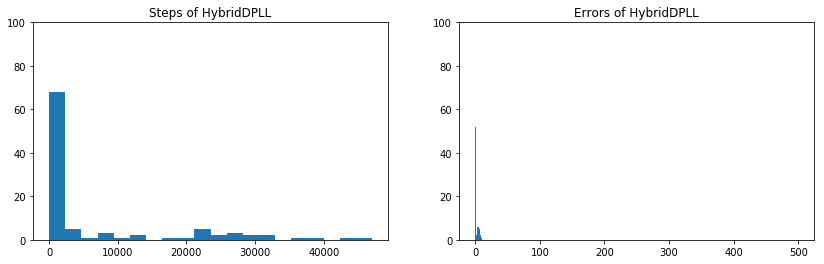

In [20]:
print_all(100, 500, 30, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [05:05<00:00,  3.08s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2325.97; stdev step: 4188.16; avg error: 1.77; stdev error: 2.29


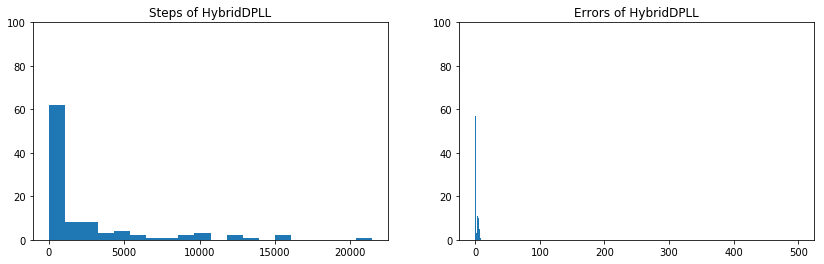

In [21]:
print_all(100, 500, 25, light=True)